<a href="https://colab.research.google.com/github/GiocomoLab/tutorials/blob/main/smoothing/spatial_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo of spatial filtering

In [76]:
import numpy as np
import pandas as pd

import scipy.signal as signal
import scipy.ndimage as ndimage
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact

In [198]:
#@title Some function definitions { display-mode: "form" }
def generate_place_field_ratemap(pf_center, pf_maxrate, pf_spread=1, 
                                 noise_maxrate=1, noise_sigma=1,
                                 mask=np.ones((50,50), dtype=bool), 
                                 env_h=None, env_w=None,
                                 seed=0):
    """
    generates a place field rate map. for each spatial bin, generates a rate

    :param pf_center, tuple of ints, location of the place field
    :param pf_rate, float >=0, mean activity rate at pf_center
    :param pf_spread, float>=0, how many bins does the activity spread with a gaussian decay
    :param noise_maxrate, float>=0, mean activity rate of noise
    :param noise_sigma, float>=0, std of acitivity rate noise
    :param mask, env_h x env_w boolean array, specifies the dimensions and masks 
      invalid bin positions
    :param env_h, int, height of the enviroment, if mask is provided this is ignored
    :param env_w, int, width of the environment, if mask is provided this is ignored
    :param seed, float, random seed
    """

    np.random.seed(seed)

    if mask is not None:
      env_h, env_w = mask.shape
    elif env_h is None:
      raise ValueError("Missing the environment dimensions")
    else:
      mask = np.ones((env_h, env_w), dtype=bool)

    # noise base
    noise_mat = np.random.normal(noise_maxrate, noise_sigma, size=(env_h, env_w))
    noise_mat[noise_mat<0] = 0
    # smooth it
    noise_mat = ndimage.gaussian_filter(noise_mat, pf_spread, mode="nearest") 

    pf_rate_map = np.zeros((env_h, env_w))

    # generate mvg 
    x = stats.multivariate_normal(pf_center, np.ones(2)*pf_spread)
    yy,xx = np.mgrid[0:env_h,0:env_w]
    pos = np.dstack((yy,xx))
    
    # scale it
    pf_rate_map = x.pdf(pos)
    pf_rate_map /= pf_rate_map.max()
    pf_rate_map *= pf_rate
    
    # add noise
    pf_rate_map += noise_mat
    
    pf_rate_map[~mask] = np.nan

    return pf_rate_map

Lets generate a place field

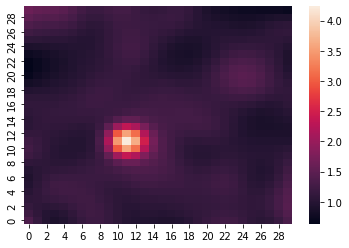

In [130]:
env_dims = (30,30)
pf_center =(11,11)
pf_rate = 3
pf_spread = 2
mask = np.ones(env_dims, dtype=bool)

pf_map = generate_place_field_ratemap(pf_center=pf_center,
                                     pf_maxrate=pf_rate, 
                                     pf_spread=pf_spread, 
                                     mask=mask, seed=1)
ax = sns.heatmap(pf_map)
ax.invert_yaxis()

now let's try some smoothing protocols. note that for the gaussian_filter function the truncate doesn't seem to have an effect.

In [202]:
@interact(sigma= np.arange(1,7), truncate=np.arange(2,13,1))
def foo(sigma, truncate):
  f,ax=plt.subplots(1,1, dpi=200)
  sm_map = ndimage.gaussian_filter(pf_map, sigma, mode='nearest', 
                                                truncate= truncate)
  ax = sns.heatmap(sm_map)
  ax.invert_yaxis()

interactive(children=(Dropdown(description='sigma', options=(1, 2, 3, 4, 5, 6), value=1), Dropdown(description…

## masking the environment

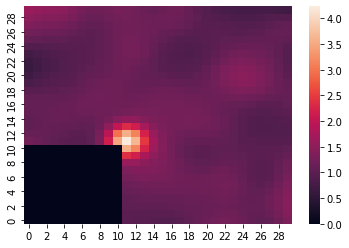

In [203]:
mask = np.ones_like(pf_map)
mask[:11,:11] = 0

pf_map_masked = pf_map*mask
ax = sns.heatmap(pf_map_masked)
ax.invert_yaxis()

In [197]:
@interact(sigma= np.arange(1,5), truncate=np.arange(3,13,2))
def foo(sigma, truncate):
  f,ax=plt.subplots(1,1, dpi=200)
  sm_map = ndimage.gaussian_filter(pf_map_masked, sigma, mode='nearest', 
                                                truncate= truncate)
  ax = sns.heatmap(sm_map)
  ax.invert_yaxis()

interactive(children=(Dropdown(description='sigma', options=(1, 2, 3, 4), value=1), Dropdown(description='trun…

problem. as you smooth, the effect of the place field lessens due to avering through the mask.

## Creating your own smoothing function

In [205]:
def convolve(img: np.array, kernel: np.array, mask: np.array) -> np.array:
    
    # Assuming a rectangular image
    convolved_img = np.zeros_like(img)
    n_rows, n_cols = img.shape
  
    k = kernel.shape[0]
    assert k==kernel.shape[1], "not supporting non-square kernels" # 
    assert k%2==1, "kernel dims must be odd" 
    pad = (k-1)//2

    mask[mask<1] = np.nan
    masked_img = img*mask
    padded_masked_img = np.pad(masked_img, pad, mode='edge')
    
    # Iterate over the rows
    for ii in range(pad, n_rows+pad):
        # Iterate over the columns
        for jj in range(pad, n_cols+pad):
            # skip over mask
            if np.isnan(mask[ii-pad, jj-pad]):
                continue
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = padded_masked_img[(ii-pad):(ii+pad+1), (jj-pad):(jj+pad+1)]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[ii-pad, jj-pad] = np.nansum(np.multiply(mat, kernel))
            
    return convolved_img

def gaussian_kernel(sigma, size):
    
    assert size>=3
    assert size%2==1

    kernel = np.zeros((size,size))

    s2 = size//2

    # generate mvg 
    x = stats.multivariate_normal([0, 0], np.ones(2)*sigma)
    yy,xx = np.mgrid[-s2:(s2+1),-s2:(s2+1)]
    p = np.dstack((yy,xx))
    return x.pdf(p)


### explore gaussian kernel and size/truncation

In [204]:
@interact(sigma=np.arange(1,5), size=np.arange(3,13,2))
def foo(sigma, size):
    sns.heatmap(gaussian_kernel(sigma,size), vmin=0)

interactive(children=(Dropdown(description='sigma', options=(1, 2, 3, 4), value=1), Dropdown(description='size…

### explore masked convolution effect on pf

In [206]:
@interact(sigma= np.arange(1,5), size=np.arange(3,13,2))
def foo(sigma, size):
    f,ax=plt.subplots(1,1, dpi=200)
    kernel= gaussian_kernel(sigma,size)
    sm_map = convolve(pf_map, kernel, mask )
    ax = sns.heatmap(sm_map)
    ax.invert_yaxis()

interactive(children=(Dropdown(description='sigma', options=(1, 2, 3, 4), value=1), Dropdown(description='size…

note how the above respects the mask when smoothing :)